In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'gaussian_noise', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}
Validation folders considered: {'gaussian_noise', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}
Test folders considered: {'gaussian_noise', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'gaussian_noise', 'chromatic_aberration', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}
Validation folders considered: {'gaussian_noise', 'chromatic_aberration', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}
Test folders considered: {'gaussian_noise', 'chromatic_aberration', 'low_resolution', 'blur', 'dirty_lens', 'lens_flare', 'motion_blur', 'original'}


In [7]:

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Module):
    """Standard convolution block: Conv2d + BatchNorm + ReLU6"""
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = norm_layer(out_planes)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu6(x, inplace=True)

class InvertedResidual(nn.Module):
    """Inverted Residual Block (Mobile Inverted Bottleneck)"""
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup
        
        layers = []
        
        if expand_ratio != 1:
            # Pointwise expansion (1x1 conv)
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        
        layers.extend([
            # Depthwise convolution (3x3 conv with groups)
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # Pointwise projection (1x1 conv without ReLU)
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MyMobileNetV2(nn.Module):
    """MobileNetV2 Implementation from Scratch"""
    def __init__(self, num_classes=4, width_mult=1.0, inverted_residual_setting=None, 
                 round_nearest=8, block=None, norm_layer=None):
        super().__init__()
        
        if block is None:
            block = InvertedResidual
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        input_channel = 32
        last_channel = 1280
        
        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],   # Stage 1
                [6, 24, 2, 2],   # Stage 2
                [6, 32, 3, 2],   # Stage 3
                [6, 64, 4, 2],   # Stage 4
                [6, 96, 3, 1],   # Stage 5
                [6, 160, 3, 2],  # Stage 6
                [6, 320, 1, 1],  # Stage 7
            ]
        
        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                           "or a 4-element list, got {}".format(inverted_residual_setting))
        
        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        
        # make it nn.Sequential
        self.features = nn.Sequential(*features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )
        
        # weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)




In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyMobileNetV2(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("MobileNetV2 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")



MobileNetV2 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
        ConvBNReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
        ConvBNReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
       ConvBNReLU-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchN


🚀 Starting MobileNetV2 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:25<00:00,  2.09it/s, Loss=1.5263, Acc=0.3386]


✅ Training completed in 25.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.0871, Acc=0.2679]


✅ Validation completed in 5.02s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.2679

📊 Epoch 1 Summary:
│ Train Loss: 1.5263 | Train Acc: 0.3386
│ Val Loss:   2.0871 | Val Acc:   0.2679
│ Train Time: 25.89s | Val Time: 5.02s
│ Total Epoch Time: 30.92s
│ Best Val Acc: 0.2679 (Epoch 1)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.86it/s, Loss=1.1973, Acc=0.5200]


✅ Training completed in 18.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.37it/s, Loss=2.6860, Acc=0.3281]


✅ Validation completed in 3.21s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.3281

📊 Epoch 2 Summary:
│ Train Loss: 1.1973 | Train Acc: 0.5200
│ Val Loss:   2.6860 | Val Acc:   0.3281
│ Train Time: 18.89s | Val Time: 3.21s
│ Total Epoch Time: 22.11s
│ Best Val Acc: 0.3281 (Epoch 2)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.86it/s, Loss=0.7839, Acc=0.7101]


✅ Training completed in 18.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.28it/s, Loss=2.7914, Acc=0.3415]


✅ Validation completed in 3.27s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.3415

📊 Epoch 3 Summary:
│ Train Loss: 0.7839 | Train Acc: 0.7101
│ Val Loss:   2.7914 | Val Acc:   0.3415
│ Train Time: 18.91s | Val Time: 3.27s
│ Total Epoch Time: 22.19s
│ Best Val Acc: 0.3415 (Epoch 3)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.4989, Acc=0.8169]


✅ Training completed in 19.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.33it/s, Loss=3.2553, Acc=0.3996]


✅ Validation completed in 3.23s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.3996

📊 Epoch 4 Summary:
│ Train Loss: 0.4989 | Train Acc: 0.8169
│ Val Loss:   3.2553 | Val Acc:   0.3996
│ Train Time: 19.06s | Val Time: 3.23s
│ Total Epoch Time: 22.30s
│ Best Val Acc: 0.3996 (Epoch 4)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.89it/s, Loss=0.3469, Acc=0.8920]


✅ Training completed in 18.69s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.51it/s, Loss=2.3273, Acc=0.4375]


✅ Validation completed in 3.11s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.4375

📊 Epoch 5 Summary:
│ Train Loss: 0.3469 | Train Acc: 0.8920
│ Val Loss:   2.3273 | Val Acc:   0.4375
│ Train Time: 18.69s | Val Time: 3.11s
│ Total Epoch Time: 21.80s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.91it/s, Loss=0.2596, Acc=0.9079]


✅ Training completed in 18.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.43it/s, Loss=2.9444, Acc=0.3147]


✅ Validation completed in 3.16s

📊 Epoch 6 Summary:
│ Train Loss: 0.2596 | Train Acc: 0.9079
│ Val Loss:   2.9444 | Val Acc:   0.3147
│ Train Time: 18.55s | Val Time: 3.16s
│ Total Epoch Time: 21.72s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.1624, Acc=0.9484]


✅ Training completed in 18.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.50it/s, Loss=3.0950, Acc=0.3906]


✅ Validation completed in 3.11s

📊 Epoch 7 Summary:
│ Train Loss: 0.1624 | Train Acc: 0.9484
│ Val Loss:   3.0950 | Val Acc:   0.3906
│ Train Time: 18.79s | Val Time: 3.11s
│ Total Epoch Time: 21.90s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.87it/s, Loss=0.1290, Acc=0.9572]


✅ Training completed in 18.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.38it/s, Loss=2.5356, Acc=0.4107]


✅ Validation completed in 3.20s

📊 Epoch 8 Summary:
│ Train Loss: 0.1290 | Train Acc: 0.9572
│ Val Loss:   2.5356 | Val Acc:   0.4107
│ Train Time: 18.80s | Val Time: 3.20s
│ Total Epoch Time: 22.01s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.87it/s, Loss=0.1507, Acc=0.9554]


✅ Training completed in 18.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.39it/s, Loss=2.9030, Acc=0.3616]


✅ Validation completed in 3.19s

📊 Epoch 9 Summary:
│ Train Loss: 0.1507 | Train Acc: 0.9554
│ Val Loss:   2.9030 | Val Acc:   0.3616
│ Train Time: 18.81s | Val Time: 3.19s
│ Total Epoch Time: 22.00s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.1290, Acc=0.9583]


✅ Training completed in 18.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.46it/s, Loss=2.9401, Acc=0.3728]


✅ Validation completed in 3.14s

📊 Epoch 10 Summary:
│ Train Loss: 0.1290 | Train Acc: 0.9583
│ Val Loss:   2.9401 | Val Acc:   0.3728
│ Train Time: 18.72s | Val Time: 3.14s
│ Total Epoch Time: 21.87s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.90it/s, Loss=0.0715, Acc=0.9800]


✅ Training completed in 18.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.37it/s, Loss=2.8412, Acc=0.3817]


✅ Validation completed in 3.21s

📊 Epoch 11 Summary:
│ Train Loss: 0.0715 | Train Acc: 0.9800
│ Val Loss:   2.8412 | Val Acc:   0.3817
│ Train Time: 18.65s | Val Time: 3.21s
│ Total Epoch Time: 21.86s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0536, Acc=0.9836]


✅ Training completed in 19.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.12it/s, Loss=2.9748, Acc=0.3862]


✅ Validation completed in 3.40s

📊 Epoch 12 Summary:
│ Train Loss: 0.0536 | Train Acc: 0.9836
│ Val Loss:   2.9748 | Val Acc:   0.3862
│ Train Time: 19.25s | Val Time: 3.40s
│ Total Epoch Time: 22.65s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.79it/s, Loss=0.0358, Acc=0.9888]


✅ Training completed in 19.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.28it/s, Loss=3.5325, Acc=0.3929]


✅ Validation completed in 3.27s

📊 Epoch 13 Summary:
│ Train Loss: 0.0358 | Train Acc: 0.9888
│ Val Loss:   3.5325 | Val Acc:   0.3929
│ Train Time: 19.36s | Val Time: 3.27s
│ Total Epoch Time: 22.63s
│ Best Val Acc: 0.4375 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.79it/s, Loss=0.0289, Acc=0.9953]


✅ Training completed in 19.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.30it/s, Loss=2.7270, Acc=0.4420]


✅ Validation completed in 3.26s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.4420

📊 Epoch 14 Summary:
│ Train Loss: 0.0289 | Train Acc: 0.9953
│ Val Loss:   2.7270 | Val Acc:   0.4420
│ Train Time: 19.38s | Val Time: 3.26s
│ Total Epoch Time: 22.64s
│ Best Val Acc: 0.4420 (Epoch 14)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.74it/s, Loss=0.0653, Acc=0.9818]


✅ Training completed in 19.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.39it/s, Loss=3.2456, Acc=0.4308]


✅ Validation completed in 3.19s

📊 Epoch 15 Summary:
│ Train Loss: 0.0653 | Train Acc: 0.9818
│ Val Loss:   3.2456 | Val Acc:   0.4308
│ Train Time: 19.71s | Val Time: 3.19s
│ Total Epoch Time: 22.91s
│ Best Val Acc: 0.4420 (Epoch 14)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.78it/s, Loss=0.0665, Acc=0.9806]


✅ Training completed in 19.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.29it/s, Loss=3.2737, Acc=0.4375]


✅ Validation completed in 3.27s

📊 Epoch 16 Summary:
│ Train Loss: 0.0665 | Train Acc: 0.9806
│ Val Loss:   3.2737 | Val Acc:   0.4375
│ Train Time: 19.41s | Val Time: 3.27s
│ Total Epoch Time: 22.68s
│ Best Val Acc: 0.4420 (Epoch 14)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0689, Acc=0.9777]


✅ Training completed in 19.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.25it/s, Loss=3.1169, Acc=0.4196]


✅ Validation completed in 3.30s

📊 Epoch 17 Summary:
│ Train Loss: 0.0689 | Train Acc: 0.9777
│ Val Loss:   3.1169 | Val Acc:   0.4196
│ Train Time: 19.09s | Val Time: 3.30s
│ Total Epoch Time: 22.39s
│ Best Val Acc: 0.4420 (Epoch 14)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.82it/s, Loss=0.0773, Acc=0.9759]


✅ Training completed in 19.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.43it/s, Loss=3.1847, Acc=0.3862]


✅ Validation completed in 3.16s

📊 Epoch 18 Summary:
│ Train Loss: 0.0773 | Train Acc: 0.9759
│ Val Loss:   3.1847 | Val Acc:   0.3862
│ Train Time: 19.14s | Val Time: 3.16s
│ Total Epoch Time: 22.30s
│ Best Val Acc: 0.4420 (Epoch 14)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0587, Acc=0.9836]


✅ Training completed in 19.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.43it/s, Loss=2.9438, Acc=0.4487]


✅ Validation completed in 3.16s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.4487

📊 Epoch 19 Summary:
│ Train Loss: 0.0587 | Train Acc: 0.9836
│ Val Loss:   2.9438 | Val Acc:   0.4487
│ Train Time: 19.04s | Val Time: 3.16s
│ Total Epoch Time: 22.21s
│ Best Val Acc: 0.4487 (Epoch 19)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.78it/s, Loss=0.1509, Acc=0.9525]


✅ Training completed in 19.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.25it/s, Loss=2.9777, Acc=0.4710]


✅ Validation completed in 3.29s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.4710

📊 Epoch 20 Summary:
│ Train Loss: 0.1509 | Train Acc: 0.9525
│ Val Loss:   2.9777 | Val Acc:   0.4710
│ Train Time: 19.40s | Val Time: 3.29s
│ Total Epoch Time: 22.70s
│ Best Val Acc: 0.4710 (Epoch 20)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.86it/s, Loss=0.0270, Acc=0.9924]


✅ Training completed in 18.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.44it/s, Loss=2.4980, Acc=0.4330]


✅ Validation completed in 3.15s

📊 Epoch 21 Summary:
│ Train Loss: 0.0270 | Train Acc: 0.9924
│ Val Loss:   2.4980 | Val Acc:   0.4330
│ Train Time: 18.87s | Val Time: 3.15s
│ Total Epoch Time: 22.02s
│ Best Val Acc: 0.4710 (Epoch 20)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0189, Acc=0.9941]


✅ Training completed in 18.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.48it/s, Loss=2.5961, Acc=0.4420]


✅ Validation completed in 3.13s

📊 Epoch 22 Summary:
│ Train Loss: 0.0189 | Train Acc: 0.9941
│ Val Loss:   2.5961 | Val Acc:   0.4420
│ Train Time: 18.96s | Val Time: 3.13s
│ Total Epoch Time: 22.09s
│ Best Val Acc: 0.4710 (Epoch 20)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0113, Acc=0.9977]


✅ Training completed in 19.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.39it/s, Loss=2.9165, Acc=0.4330]


✅ Validation completed in 3.19s

📊 Epoch 23 Summary:
│ Train Loss: 0.0113 | Train Acc: 0.9977
│ Val Loss:   2.9165 | Val Acc:   0.4330
│ Train Time: 19.28s | Val Time: 3.19s
│ Total Epoch Time: 22.48s
│ Best Val Acc: 0.4710 (Epoch 20)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0050, Acc=0.9988]


✅ Training completed in 18.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.53it/s, Loss=2.7944, Acc=0.4598]


✅ Validation completed in 3.09s

📊 Epoch 24 Summary:
│ Train Loss: 0.0050 | Train Acc: 0.9988
│ Val Loss:   2.7944 | Val Acc:   0.4598
│ Train Time: 18.73s | Val Time: 3.09s
│ Total Epoch Time: 21.83s
│ Best Val Acc: 0.4710 (Epoch 20)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0082, Acc=0.9982]


✅ Training completed in 18.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.48it/s, Loss=3.0019, Acc=0.4844]


✅ Validation completed in 3.13s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.4844

📊 Epoch 25 Summary:
│ Train Loss: 0.0082 | Train Acc: 0.9982
│ Val Loss:   3.0019 | Val Acc:   0.4844
│ Train Time: 18.92s | Val Time: 3.13s
│ Total Epoch Time: 22.05s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0248, Acc=0.9918]


✅ Training completed in 18.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.34it/s, Loss=3.1024, Acc=0.4509]


✅ Validation completed in 3.23s

📊 Epoch 26 Summary:
│ Train Loss: 0.0248 | Train Acc: 0.9918
│ Val Loss:   3.1024 | Val Acc:   0.4509
│ Train Time: 18.77s | Val Time: 3.23s
│ Total Epoch Time: 22.00s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.86it/s, Loss=0.0664, Acc=0.9906]


✅ Training completed in 18.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.36it/s, Loss=3.5308, Acc=0.4174]


✅ Validation completed in 3.21s

📊 Epoch 27 Summary:
│ Train Loss: 0.0664 | Train Acc: 0.9906
│ Val Loss:   3.5308 | Val Acc:   0.4174
│ Train Time: 18.88s | Val Time: 3.21s
│ Total Epoch Time: 22.10s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.2146, Acc=0.9366]


✅ Training completed in 18.76s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.47it/s, Loss=3.0780, Acc=0.4308]


✅ Validation completed in 3.13s

📊 Epoch 28 Summary:
│ Train Loss: 0.2146 | Train Acc: 0.9366
│ Val Loss:   3.0780 | Val Acc:   0.4308
│ Train Time: 18.76s | Val Time: 3.13s
│ Total Epoch Time: 21.90s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0665, Acc=0.9754]


✅ Training completed in 19.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.42it/s, Loss=3.4647, Acc=0.4219]


✅ Validation completed in 3.17s

📊 Epoch 29 Summary:
│ Train Loss: 0.0665 | Train Acc: 0.9754
│ Val Loss:   3.4647 | Val Acc:   0.4219
│ Train Time: 19.09s | Val Time: 3.17s
│ Total Epoch Time: 22.26s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0168, Acc=0.9953]


✅ Training completed in 18.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.45it/s, Loss=2.9480, Acc=0.4219]


✅ Validation completed in 3.15s

📊 Epoch 30 Summary:
│ Train Loss: 0.0168 | Train Acc: 0.9953
│ Val Loss:   2.9480 | Val Acc:   0.4219
│ Train Time: 18.78s | Val Time: 3.15s
│ Total Epoch Time: 21.93s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0217, Acc=0.9935]


✅ Training completed in 19.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.29it/s, Loss=3.2190, Acc=0.4241]


✅ Validation completed in 3.26s

📊 Epoch 31 Summary:
│ Train Loss: 0.0217 | Train Acc: 0.9935
│ Val Loss:   3.2190 | Val Acc:   0.4241
│ Train Time: 19.04s | Val Time: 3.26s
│ Total Epoch Time: 22.30s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.82it/s, Loss=0.0244, Acc=0.9894]


✅ Training completed in 19.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.28it/s, Loss=2.7962, Acc=0.4710]


✅ Validation completed in 3.28s

📊 Epoch 32 Summary:
│ Train Loss: 0.0244 | Train Acc: 0.9894
│ Val Loss:   2.7962 | Val Acc:   0.4710
│ Train Time: 19.14s | Val Time: 3.28s
│ Total Epoch Time: 22.42s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0317, Acc=0.9906]


✅ Training completed in 19.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.36it/s, Loss=3.0306, Acc=0.4330]


✅ Validation completed in 3.21s

📊 Epoch 33 Summary:
│ Train Loss: 0.0317 | Train Acc: 0.9906
│ Val Loss:   3.0306 | Val Acc:   0.4330
│ Train Time: 19.23s | Val Time: 3.21s
│ Total Epoch Time: 22.45s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0249, Acc=0.9935]


✅ Training completed in 19.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.29it/s, Loss=2.9385, Acc=0.4420]


✅ Validation completed in 3.27s

📊 Epoch 34 Summary:
│ Train Loss: 0.0249 | Train Acc: 0.9935
│ Val Loss:   2.9385 | Val Acc:   0.4420
│ Train Time: 19.30s | Val Time: 3.27s
│ Total Epoch Time: 22.56s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0153, Acc=0.9935]


✅ Training completed in 19.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.42it/s, Loss=3.6237, Acc=0.4665]


✅ Validation completed in 3.17s

📊 Epoch 35 Summary:
│ Train Loss: 0.0153 | Train Acc: 0.9935
│ Val Loss:   3.6237 | Val Acc:   0.4665
│ Train Time: 19.07s | Val Time: 3.17s
│ Total Epoch Time: 22.25s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0288, Acc=0.9912]


✅ Training completed in 19.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.13it/s, Loss=3.3765, Acc=0.4688]


✅ Validation completed in 3.39s

📊 Epoch 36 Summary:
│ Train Loss: 0.0288 | Train Acc: 0.9912
│ Val Loss:   3.3765 | Val Acc:   0.4688
│ Train Time: 19.12s | Val Time: 3.39s
│ Total Epoch Time: 22.52s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.78it/s, Loss=0.0242, Acc=0.9918]


✅ Training completed in 19.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.44it/s, Loss=4.4782, Acc=0.4018]


✅ Validation completed in 3.15s

📊 Epoch 37 Summary:
│ Train Loss: 0.0242 | Train Acc: 0.9918
│ Val Loss:   4.4782 | Val Acc:   0.4018
│ Train Time: 19.40s | Val Time: 3.15s
│ Total Epoch Time: 22.56s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0421, Acc=0.9842]


✅ Training completed in 18.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.51it/s, Loss=3.7267, Acc=0.4353]


✅ Validation completed in 3.11s

📊 Epoch 38 Summary:
│ Train Loss: 0.0421 | Train Acc: 0.9842
│ Val Loss:   3.7267 | Val Acc:   0.4353
│ Train Time: 18.95s | Val Time: 3.11s
│ Total Epoch Time: 22.06s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0533, Acc=0.9865]


✅ Training completed in 19.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.40it/s, Loss=3.8008, Acc=0.4129]


✅ Validation completed in 3.19s

📊 Epoch 39 Summary:
│ Train Loss: 0.0533 | Train Acc: 0.9865
│ Val Loss:   3.8008 | Val Acc:   0.4129
│ Train Time: 19.10s | Val Time: 3.19s
│ Total Epoch Time: 22.29s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.79it/s, Loss=0.1107, Acc=0.9654]


✅ Training completed in 19.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.30it/s, Loss=3.3765, Acc=0.4241]


✅ Validation completed in 3.25s

📊 Epoch 40 Summary:
│ Train Loss: 0.1107 | Train Acc: 0.9654
│ Val Loss:   3.3765 | Val Acc:   0.4241
│ Train Time: 19.39s | Val Time: 3.25s
│ Total Epoch Time: 22.65s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0622, Acc=0.9765]


✅ Training completed in 19.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.26it/s, Loss=3.3504, Acc=0.4196]


✅ Validation completed in 3.29s

📊 Epoch 41 Summary:
│ Train Loss: 0.0622 | Train Acc: 0.9765
│ Val Loss:   3.3504 | Val Acc:   0.4196
│ Train Time: 19.19s | Val Time: 3.29s
│ Total Epoch Time: 22.48s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.75it/s, Loss=0.0528, Acc=0.9853]


✅ Training completed in 19.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.19it/s, Loss=3.5817, Acc=0.4107]


✅ Validation completed in 3.34s

📊 Epoch 42 Summary:
│ Train Loss: 0.0528 | Train Acc: 0.9853
│ Val Loss:   3.5817 | Val Acc:   0.4107
│ Train Time: 19.65s | Val Time: 3.34s
│ Total Epoch Time: 22.99s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0121, Acc=0.9971]


✅ Training completed in 19.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.37it/s, Loss=3.5356, Acc=0.4397]


✅ Validation completed in 3.21s

📊 Epoch 43 Summary:
│ Train Loss: 0.0121 | Train Acc: 0.9971
│ Val Loss:   3.5356 | Val Acc:   0.4397
│ Train Time: 19.05s | Val Time: 3.21s
│ Total Epoch Time: 22.26s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.79it/s, Loss=0.0163, Acc=0.9959]


✅ Training completed in 19.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.33it/s, Loss=3.7354, Acc=0.3728]


✅ Validation completed in 3.24s

📊 Epoch 44 Summary:
│ Train Loss: 0.0163 | Train Acc: 0.9959
│ Val Loss:   3.7354 | Val Acc:   0.3728
│ Train Time: 19.34s | Val Time: 3.24s
│ Total Epoch Time: 22.58s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0055, Acc=0.9971]


✅ Training completed in 19.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.45it/s, Loss=3.3954, Acc=0.4308]


✅ Validation completed in 3.15s

📊 Epoch 45 Summary:
│ Train Loss: 0.0055 | Train Acc: 0.9971
│ Val Loss:   3.3954 | Val Acc:   0.4308
│ Train Time: 19.24s | Val Time: 3.15s
│ Total Epoch Time: 22.39s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0041, Acc=0.9994]


✅ Training completed in 19.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.23it/s, Loss=3.6591, Acc=0.3973]


✅ Validation completed in 3.31s

📊 Epoch 46 Summary:
│ Train Loss: 0.0041 | Train Acc: 0.9994
│ Val Loss:   3.6591 | Val Acc:   0.3973
│ Train Time: 19.09s | Val Time: 3.31s
│ Total Epoch Time: 22.41s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.77it/s, Loss=0.0078, Acc=0.9982]


✅ Training completed in 19.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.25it/s, Loss=3.7567, Acc=0.3996]


✅ Validation completed in 3.30s

📊 Epoch 47 Summary:
│ Train Loss: 0.0078 | Train Acc: 0.9982
│ Val Loss:   3.7567 | Val Acc:   0.3996
│ Train Time: 19.49s | Val Time: 3.30s
│ Total Epoch Time: 22.79s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.82it/s, Loss=0.0025, Acc=0.9994]


✅ Training completed in 19.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.41it/s, Loss=3.5224, Acc=0.4487]


✅ Validation completed in 3.18s

📊 Epoch 48 Summary:
│ Train Loss: 0.0025 | Train Acc: 0.9994
│ Val Loss:   3.5224 | Val Acc:   0.4487
│ Train Time: 19.18s | Val Time: 3.18s
│ Total Epoch Time: 22.37s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.76it/s, Loss=0.0006, Acc=1.0000]


✅ Training completed in 19.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.22it/s, Loss=3.4180, Acc=0.4442]


✅ Validation completed in 3.32s

📊 Epoch 49 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   3.4180 | Val Acc:   0.4442
│ Train Time: 19.56s | Val Time: 3.32s
│ Total Epoch Time: 22.88s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:19<00:00,  2.76it/s, Loss=0.0005, Acc=1.0000]


✅ Training completed in 19.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.35it/s, Loss=3.4846, Acc=0.4509]


✅ Validation completed in 3.22s

📊 Epoch 50 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   3.4846 | Val Acc:   0.4509
│ Train Time: 19.56s | Val Time: 3.22s
│ Total Epoch Time: 22.78s
│ Best Val Acc: 0.4844 (Epoch 25)
│ GPU Memory: 0.1GB / 2.8GB

💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'
📊 Best model stats:
│ Best Epoch: 25
│ Best Val Acc: 0.4844

💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'

🎉 MobileNetV2 Training Complete!
Total Training Time: 1124.46s (18.7 minutes)
Average Epoch Time: 22.49s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 30.92s
│ Epoch 2: 22.11s
│ Epoch 3: 22.19s
│ Epoch 4: 22.30s
│ Epoch 5: 21.80s
│ Epoch 6: 21.72s
│ Epoch 7: 21.90s
│ Epoch 8: 22.01s
│ Epoch 9: 22.00s
│ Epoch 10: 21.87s
│ Epoch 11: 21.86s
│ Epoch 12: 22.65s
│ Epoch 13: 22.63s
│ Epoch 14: 22.64s
│ Epoch 15: 22.91s
│ Epoch 16: 22.68s
│ Epoch 17: 22.39s
│ Epoch 18: 22.30s
│ Epoch 19: 22.21s
│ Epoch 20: 22.70s
│ Epoch 21: 22.02s
│ Epoch 22: 

Testing MobileNetV2: 100%|██████████████████████████████| 18/18 [00:10<00:00,  1.78it/s]


✅ MobileNetV2 Testing completed in 10.13s

📋 MobileNetV2 Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.47      0.49      0.48       152
catching_a_ball       0.28      0.42      0.34       104
    diving_stop       0.00      0.00      0.00        56
        run_out       0.57      0.39      0.46       128
       stumping       0.49      0.59      0.54       120

       accuracy                           0.43       560
      macro avg       0.36      0.38      0.36       560
   weighted avg       0.42      0.43      0.41       560

🎯 MobileNetV2 Test Accuracy: 0.4286

📊 MobileNetV2 Model Performance Summary:
│ Best Validation Acc:  0.4844 (Epoch 25)
│ Final Test Accuracy:  0.4286
│ Val-Test Gap:         0.0558


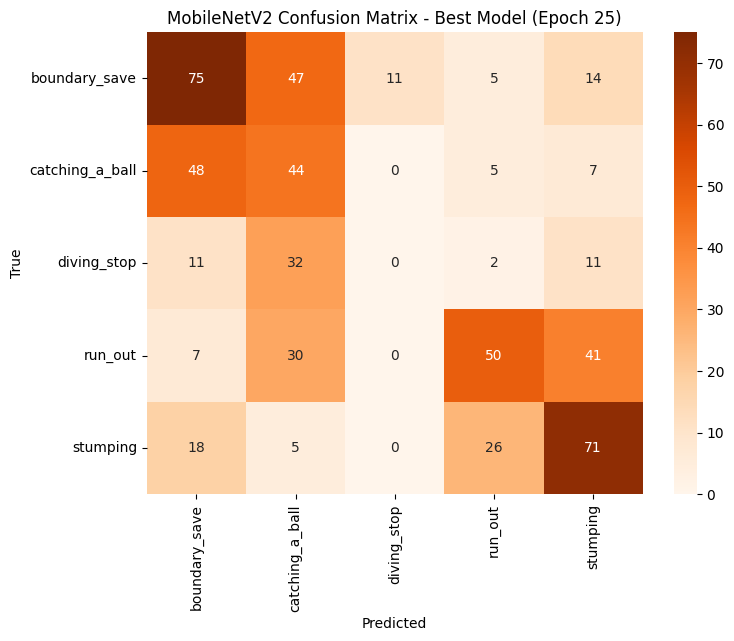

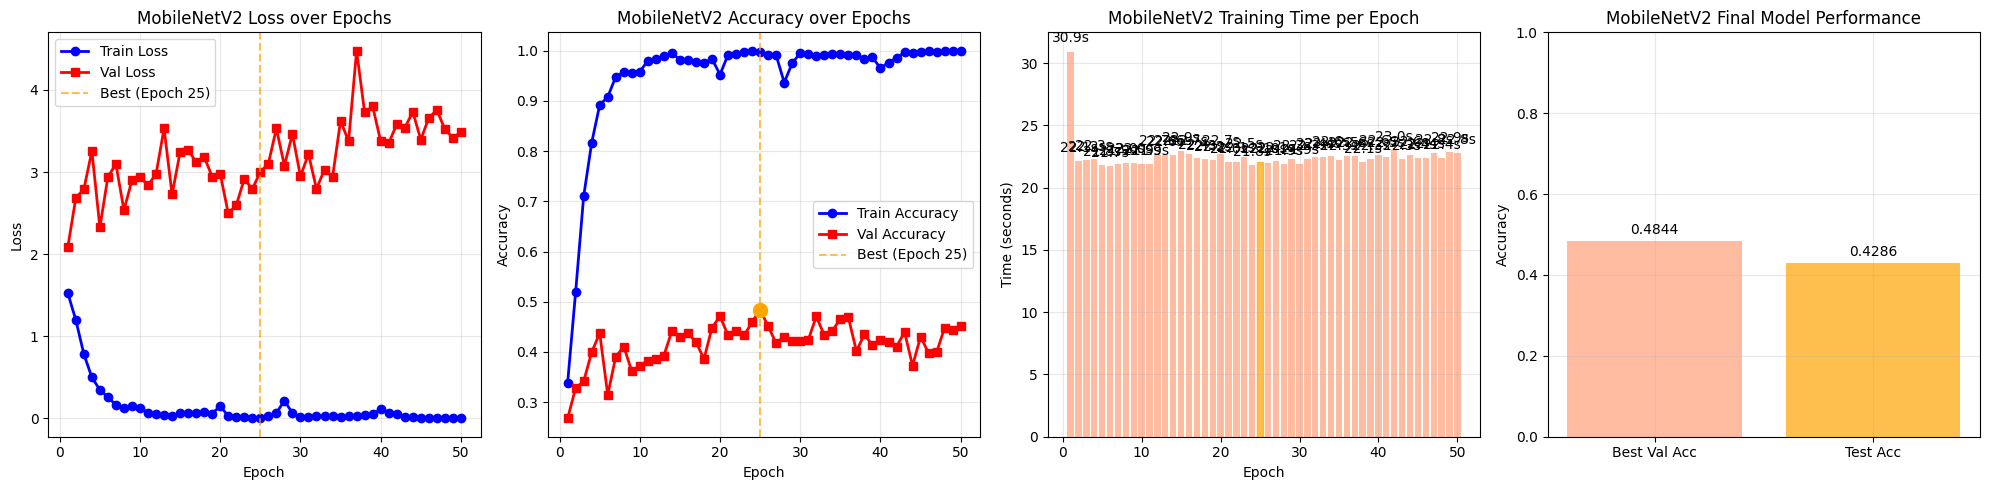


⏰ MobileNetV2 Final Timing Summary:
│ Total Training: 1124.46s
│ Average per Epoch: 22.49s
│ Testing Time: 10.13s
│ Total Runtime: 1134.59s

💾 MobileNetV2 Files saved:
│ best_mobilenetv2_model.pth - Best validation accuracy model
│ mobilenetv2_training_history.csv - Training metrics for later plotting

🏗️  MobileNetV2 Architecture Summary:
│ Total Parameters: 2,230,277
│ Trainable Parameters: 2,230,277
│ Model Size: 8.51 MB
│ Input Size: 224x224x3
│ Output Classes: 5
│ Width Multiplier: 1.0
│ Inverted Residual Blocks: 17
│ Depthwise Separable Convs: Yes
│ ReLU6 Activation: Yes


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - MobileNetV2
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting MobileNetV2 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best MobileNetV2 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_mobilenetv2_model.pth')
    print(f"\n💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('mobilenetv2_training_history.csv', index=False)
print("\n💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'")

# Training Summary
print(f"\n🎉 MobileNetV2 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best MobileNetV2 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best MobileNetV2 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing MobileNetV2", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ MobileNetV2 Testing completed in {test_time:.2f}s")
print("\n📋 MobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 MobileNetV2 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 MobileNetV2 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"MobileNetV2 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='orange', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightsalmon', alpha=0.7)
bars[best_epoch-1].set_color('orange')
plt.title("MobileNetV2 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightsalmon', 'orange']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ MobileNetV2 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 MobileNetV2 Files saved:")
print(f"│ best_mobilenetv2_model.pth - Best validation accuracy model")
print(f"│ mobilenetv2_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. MobileNetV2 Architecture Summary
# -----------------------------
print(f"\n🏗️  MobileNetV2 Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Width Multiplier: 1.0")
print(f"│ Inverted Residual Blocks: 17")
print(f"│ Depthwise Separable Convs: Yes")
print(f"│ ReLU6 Activation: Yes")